# 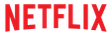 **Customer Churn Prediction**

##**Import Required Libraries**



In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


##**Load and Rename Dataset**


In [43]:
import kagglehub

# Download latest version dataset from kaggle
path = kagglehub.dataset_download("abdulwadood11220/netflix-customer-churn-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/netflix-customer-churn-dataset


In [44]:
import os

# List all files and their names in the dataset folder
files = os.listdir(path)
print("Files in dataset folder:", files)


Files in dataset folder: ['netflix_customer_churn.csv']


In [45]:
# Load the CSV file into a DataFram
df = pd.read_csv(os.path.join(path, 'netflix_customer_churn.csv'))

# View the first few rows
df.head()


,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [46]:
# Rename columns for clarity
df.rename(columns={
    'ida': 'customer_id',
    'ege': 'age',
    'subscription': 'subscription_type',
    'watch hours': 'watch_hours',
    'last login day': 'last_login_days',
    'fee': 'monthly_fee',
    'leave or not': 'churned'
}, inplace=True)

# View the first few rows
df.head()


,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


##**Initial Data Exploration & Cleaning**

In [47]:
# Dataset overview
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())



(5000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), obje

In [48]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop customer_id (not useful for prediction)
df.drop('customer_id', axis=1, inplace=True)


In [49]:
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


##**Label Encode Categorical Features**

In [50]:

# Label encode categorical features
le = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,2,0,14.73,29,0,3,8.99,1,3,1,0.49,0
1,47,2,2,0.70,19,2,2,13.99,1,3,5,0.03,6
2,27,0,2,16.32,10,1,3,13.99,0,1,2,1.48,3
3,53,2,1,4.51,12,4,3,17.99,1,1,2,0.35,4
4,56,2,2,1.89,13,0,2,13.99,1,1,2,0.13,0


##**Correlation Matrix**

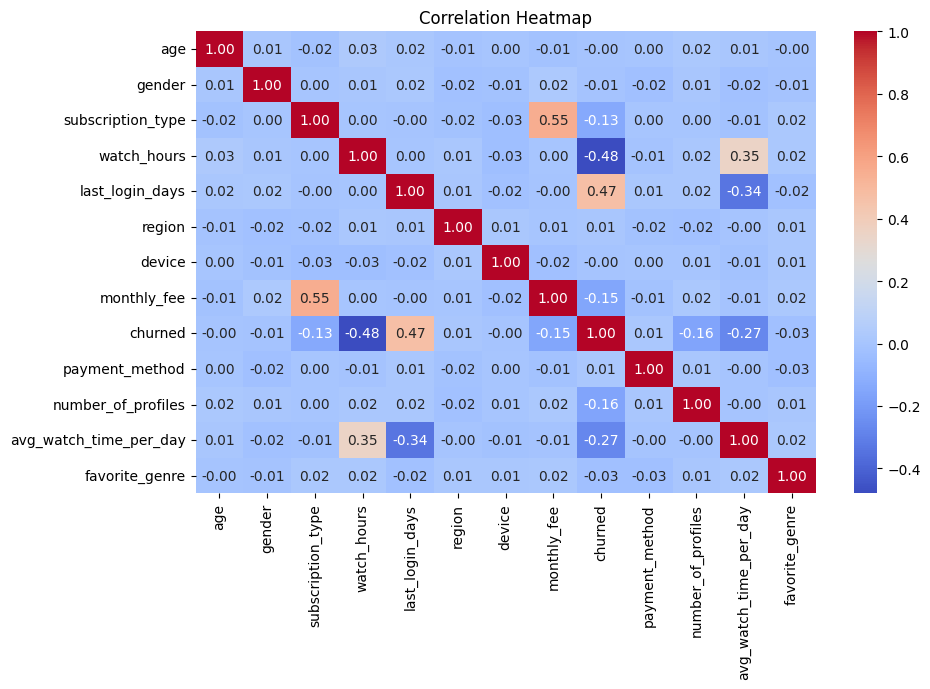

In [51]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


##**Split into Features and Target**


In [52]:
X = df.drop('churned', axis=1) # Removing churned from features
y = df['churned'] # Target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## **Train 3 Classifiers**
###**1. Logistic Regression**


In [54]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(y_pred_log)


[0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0
 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1
 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0
 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1
 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0
 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1
 0 1 1 1 1 1 1 1 0 1 0 1 

##**2. Random Forest**

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(y_pred_rf)

[0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0
 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1
 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0
 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 

##**3. XGBoost**

In [56]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(y_pred_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:58:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0
 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0
 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1
 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1
 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0
 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 

##**Evaluation Function & Results**

In [58]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"📌 {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


📌 Logistic Regression
Accuracy: 0.877
Confusion Matrix:
 [[431  67]
 [ 56 446]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       498
           1       0.87      0.89      0.88       502

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

📌 Random Forest
Accuracy: 0.975
Confusion Matrix:
 [[490   8]
 [ 17 485]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       498
           1       0.98      0.97      0.97       502

    accuracy                           0.97      1000
   macro avg       0.98      0.98      0.97      1000
weighted avg       0.98      0.97      0.97      1000

📌 XGBoost
Accuracy: 0.995
Confusion Matrix:
 [[497   1]
 [  4 498]]
Classification Report:
               precision    recall  f1-score   suppor

##**Hyperparameter Tuning- Logistic Regression**

In [59]:

# Define parameter grid
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],     # Inverse of regularization strength
    'solver': ['lbfgs'],                # Must match penalty
    'max_iter': [100, 200, 500],
    'class_weight': [None, 'balanced']
}

# Grid Search
grid_log = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_log.fit(X_train, y_train)

# Best model
print("Best Hyperparameters:", grid_log.best_params_)
best_log_model = grid_log.best_estimator_

# Evaluate
y_pred_best_log = best_log_model.predict(X_test)

evaluate_model(y_test, y_pred_best_log, "Tuned Logistic Regression")


Best Hyperparameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
📌 Tuned Logistic Regression
Accuracy: 0.876
Confusion Matrix:
 [[431  67]
 [ 57 445]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       498
           1       0.87      0.89      0.88       502

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [61]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 4]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest")


Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
📌 Tuned Random Forest
Accuracy: 0.979
Confusion Matrix:
 [[491   7]
 [ 14 488]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       498
           1       0.99      0.97      0.98       502

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



##**Feature Importance Plot- Random Forest**

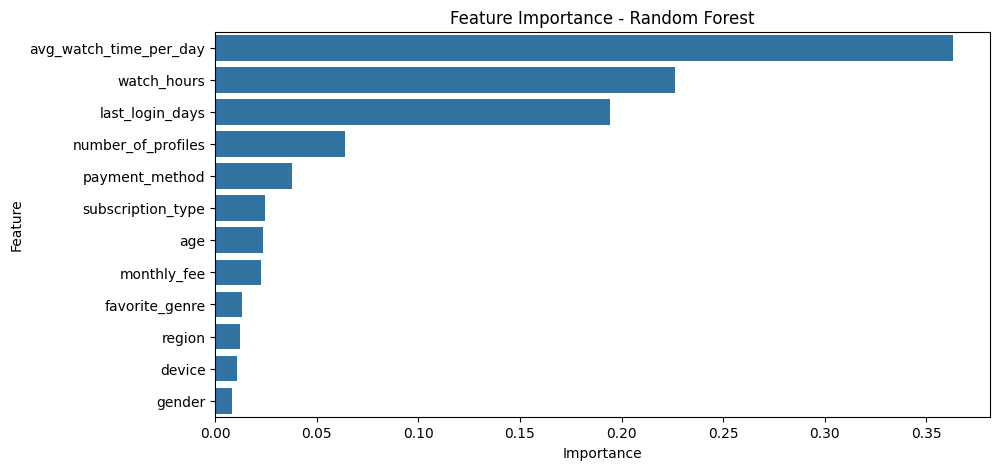

In [62]:
# Feature names from original df
feature_names = X.columns

importances = best_rf.feature_importances_
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance - Random Forest")
plt.show()


##**Feature Importance Plot- XGBOOST**

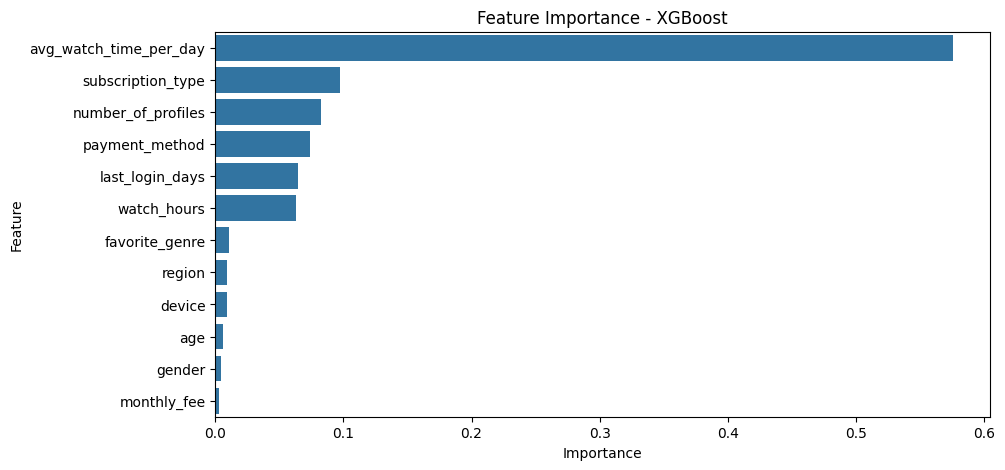

In [63]:
# Get importance from XGBoost
xgb_importances = xgb.feature_importances_

# Plot
feat_df_xgb = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances})
feat_df_xgb.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df_xgb)
plt.title("Feature Importance - XGBoost")
plt.show()


##**Feature Importance Plot- Logistic Regression**

In logistic regression, coefficients indicate importance:

Positive → increases chance of churn

Negative → reduces chance of churn

Larger magnitude → more impact

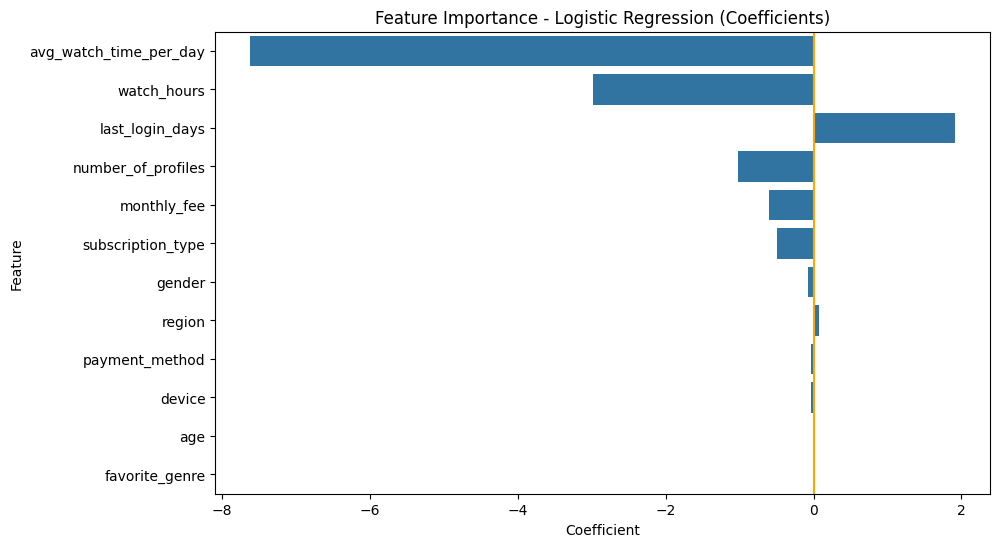

In [68]:
# Get coefficients
coef = best_log_model.coef_[0]
features = X.columns

# Create DataFrame
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.axvline(0, color='orange', linestyle='solid')
plt.title("Feature Importance - Logistic Regression (Coefficients)")
plt.show()


##**Model Comparison Summary**
| Metric                  | Logistic Regression | Random Forest | XGBoost     |
| ----------------------- | ------------------- | ------------- | ----------- |
| **Accuracy**            | 87.7%               | 97.5%         | **99.5%** ✅ |
| **Precision (Class 1)** | 0.87                | 0.98          | **1.00** ✅  |
| **Recall (Class 1)**    | 0.89                | 0.97          | **0.99** ✅  |
| **F1-score (Class 1)**  | 0.88                | 0.97          | **1.00** ✅  |

### **Conclusion:**

**XGBoost is the Best Model**

- Highest accuracy (99.5%)

- Excellent precision, recall, and F1-score

- Confusion Matrix shows very few errors (only 5 total misclassified out of 1000)

- So we will export the XGBoost model.

##**How to Export a Trained Model?**
You can use either joblib or pickle

In [69]:
pip install joblib


**Export Model with joblib**

In [70]:
import joblib

# Save the model
joblib.dump(xgb, 'xgboost_churn_model.pkl')


['xgboost_churn_model.pkl']

**Load the Model Later**

In [71]:
# Load the model
# loaded_model = joblib.load('xgboost_churn_model.pkl')

# Use it to predict
# pred = loaded_model.predict(X_test)


**If you used StandardScaler, export it with the model:**

In [72]:
# Save scaler
# joblib.dump(scaler, 'scaler.pkl')

# Later load it
# scaler = joblib.load('scaler.pkl')
# X_scaled = scaler.transform(new_data)


**We can load it anytime and use it to predict churn on new Netflix customer data**

Deploying your **XGBoost model on AWS SageMaker** is a powerful and production-ready way to serve your model as a REST API.

---

##  Step-by-Step Guide to Deploy XGBoost Model on AWS SageMaker

###  Pre-requisites:

*  An AWS account
*  IAM role with **SageMaker, S3, and ECR permissions**
*  Install the `boto3` and `sagemaker` SDKs:

```bash
pip install sagemaker boto3
```

---

## Step 1: Import Libraries & Setup

```python
import sagemaker
import boto3
from sagemaker import get_execution_role

# Start SageMaker session
sagemaker_session = sagemaker.Session()
role = get_execution_role()  # or paste your role ARN manually if local

# Your default S3 bucket
bucket = sagemaker_session.default_bucket()
prefix = "xgboost-churn-project"
```

---

## Step 2: Save & Upload Model to S3

```python
import joblib
import os

# Save model locally
joblib.dump(xgb, "xgboost_model.pkl")

# Upload to S3
model_path = sagemaker_session.upload_data("xgboost_model.pkl", bucket=bucket, key_prefix=prefix)
print("Model uploaded to:", model_path)
```

---

## Step 3: Create a SageMaker Model from XGBoost Container

```python
from sagemaker.xgboost.model import XGBoostModel

xgb_model = XGBoostModel(
    model_data=model_path,
    role=role,
    entry_point="inference.py",  # Script for preprocessing + predict
    framework_version="1.5-1",   # XGBoost version
    sagemaker_session=sagemaker_session
)
```

---

## Step 4: Write `inference.py` Script

Save a file called `inference.py` with:

```python
import xgboost as xgb
import joblib
import numpy as np
import os
import json

def model_fn(model_dir):
    model = joblib.load(os.path.join(model_dir, "xgboost_model.pkl"))
    return model

def input_fn(request_body, request_content_type):
    if request_content_type == "application/json":
        return np.array(json.loads(request_body)["data"])
    raise ValueError("Unsupported content type")

def predict_fn(input_data, model):
    prediction = model.predict(input_data)
    return prediction.tolist()
```

> Upload this file to the same directory before calling `entry_point='inference.py'`

---

## Step 5: Deploy as Real-Time Endpoint

```python
predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"  # or "ml.t2.medium" for free tier
)
```

---

## Step 6: Make Predictions Using Endpoint

```python
# Set content type
predictor.content_type = "application/json"

# Sample input (use scaled features)
data = {
    "data": X_test[:1].tolist()  # just one row
}

# Predict
response = predictor.predict(data)
print("Prediction:", response)
```

---

##  Step 7: Cleanup (Stop Billing)

```python
predictor.delete_endpoint()
```

---

## Summary

| Step                 | What You Did                         |
| -------------------- | ------------------------------------ |
| Upload model to S3   | Used `sagemaker_session.upload_data` |
| Defined inference    | Wrote `inference.py`                 |
| Created model        | With `XGBoostModel()`                |
| Deployed to endpoint | With `.deploy()`                     |
| Made predictions     | Using the REST endpoint              |


